In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
import torchvision.datasets

In [2]:
# generate an artificial classification problem
N = 50

# Observations from class A and B come from two normal
# distributions with different mean, but same covariance
mean_classA = np.array([-1 , -1])
mean_classB = np.array([1 , 1])
cov = 1*np.identity(n=2)

X_classA = np.random.multivariate_normal(mean_classA, cov, N//2)
X_classB = np.random.multivariate_normal(mean_classB, cov, N//2)
X = np.concatenate((X_classA, X_classB))

y_classA = np.full((N//2, ), 1, dtype=np.bool_)
y_classB = np.full((N//2, ), 0, dtype=np.bool_)
y = np.concatenate((y_classA, y_classB))

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

X.shape, y.shape

(torch.Size([50, 2]), torch.Size([50]))

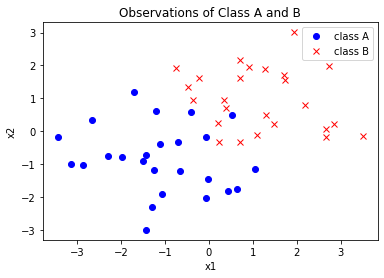

In [3]:
plt.plot(X_classA[:, 0], X_classA[:, 1], "bo", label="class A")
plt.plot(X_classB[:, 0], X_classB[:, 1], "rx", label="class B")
plt.title("Observations of Class A and B")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

## Simple Neural Network using Pytorch

The neural network will be equivalent to a logistic regression.

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 1, bias=True) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

**Visualization of the Network**

<img src="https://i.imgur.com/mXJD4Pf.png" alt="Drawing" style="width: 500px;"/>

The network has 3 learnable weights, thereof

* 2 weights $w_1, w_2$ associated with the single hidden unit $a_1$
* 1 weight $b$ for the bias of the hidden layer

Final Accuracy: 94.0%


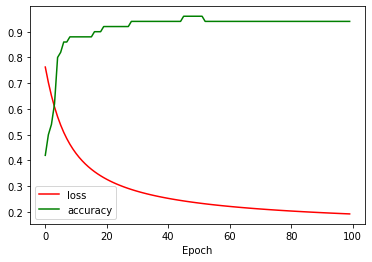

In [5]:
# training loop 
net = Net()
criterion = nn.BCELoss()
optim = torch.optim.SGD(net.parameters(), lr=0.1)

EPOCHS = 100
losses = []
accuracies = []
for i in range(EPOCHS):
    net.zero_grad()
    out = net(X)
    out = out.reshape((-1, )) # from (N, 1) to (N, )
    
    loss = criterion(out, y)
    losses.append(loss)
    
    preds = out > 0.5
    accuracy = np.sum(preds.detach().numpy() == y.numpy()) / X.shape[0]
    accuracies.append(accuracy)
    
    loss.backward()
    optim.step()


print(f"Final Accuracy: {accuracy*100}%")

plt.plot(losses, "r-", label="loss")
plt.plot(accuracies, "g-", label="accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [82]:
def n_parameters(model):
    n = 0
    for _, param in model.named_parameters():
        if param.requires_grad:
            n += len(param.data)
    return n

def print_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)
    return None

# print learnable parameters
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.data)

weights = [param.data for name, param in net.named_parameters() if "weight" in name][0].reshape(-1,)
bias = [param.data for name, param in net.named_parameters() if "bias" in name][0]

fc1.weight tensor([[-1.2496, -1.2597]])
fc1.bias tensor([0.0054])


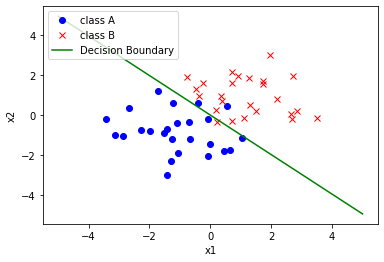

In [7]:
# plot the learned decision boundary

# **Derivation**
#      0 = b + w0*x1 + w1*x2
# <=> x2 = -b/w1 -(wo/w1)*x1

def decision_boundary(x1, bias, weights):
    intercept = -bias/weights[1]
    slope = -weights[0]/weights[1]
    return intercept + slope*x1

xx = np.linspace(-5, 5, 50)
yy = decision_boundary(xx, bias, weights)

plt.plot(X_classA[:, 0], X_classA[:, 1], "bo", label="class A")
plt.plot(X_classB[:, 0], X_classB[:, 1], "rx", label="class B")
plt.plot(xx, yy, "g-", label="Decision Boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(loc="upper left")
plt.show()

## The same neural network, but *from scratch* (with the help of Autograd)

In [8]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def cross_entropy_loss(preds, targets):
    losses = -(targets*torch.log(preds) + (1-targets)*torch.log(1-preds))
    loss = losses.mean()
    return loss

In [9]:
# init learnable weights of the network
W = torch.rand((2, 1), requires_grad=True)
b = torch.rand((1, ), requires_grad=True)

print(W)
print(b)

tensor([[0.5565],
        [0.6178]], requires_grad=True)
tensor([0.0140], requires_grad=True)


In [10]:
# forward path
print((X.shape, W.shape, b.shape))

out = X@W + b 
print(out.shape)

out = torch.reshape(out, (out.shape[0], ))
print(out.shape)

preds = sigmoid(out)
print(preds.shape)

preds

(torch.Size([50, 2]), torch.Size([2, 1]), torch.Size([1]))
torch.Size([50, 1])
torch.Size([50])
torch.Size([50])


tensor([0.1185, 0.1715, 0.2483, 0.4680, 0.4510, 0.2271, 0.2911, 0.2153, 0.1959,
        0.2976, 0.2004, 0.2219, 0.0876, 0.4651, 0.1061, 0.1500, 0.4287, 0.0978,
        0.3578, 0.5366, 0.1475, 0.0669, 0.6475, 0.2992, 0.3281, 0.9401, 0.8826,
        0.7279, 0.8749, 0.8510, 0.5514, 0.4838, 0.6840, 0.8009, 0.7403, 0.8496,
        0.6603, 0.8236, 0.8482, 0.5992, 0.6344, 0.8506, 0.8678, 0.8668, 0.6865,
        0.8042, 0.6387, 0.7064, 0.9506, 0.5701], grad_fn=<MulBackward0>)

In [11]:
# autograd & weight update
loss = cross_entropy_loss(preds=preds, targets=y)
loss.backward()

print(W.grad)
print(b.grad)

LEARN_RATE = 0.01
W = W - LEARN_RATE * W.grad
b = b - LEARN_RATE * b.grad

tensor([[0.9563],
        [0.7488]])
tensor([0.0144])


Putting it all together

In [12]:
X.shape, y.shape

(torch.Size([50, 2]), torch.Size([50]))

tensor([[-1.2414],
        [-1.2041]], requires_grad=True)
tensor([0.2154], requires_grad=True)
final accuracy:96.0%


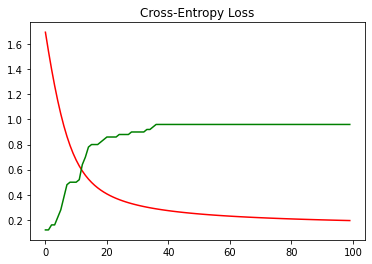

In [13]:
W = torch.rand((2, 1), requires_grad=True)
b = torch.rand((1, ), requires_grad=True)

EPOCHS = 100
LEARN_RATE = 0.1
losses = []
accuracies = []
for i in range(EPOCHS):
    out = X@W + b
    out = out.reshape((X.shape[0], ))
    preds = sigmoid(out)
    loss = cross_entropy_loss(preds=preds, targets=y)
    losses.append(loss)
    
    # accuracy
    pred_classes = preds > 0.5
    accuracy = np.sum(pred_classes.detach().numpy() == y.numpy()) / X.shape[0]
    accuracies.append(accuracy)
    
    # backward path
    loss.backward()
    
    # weight update
    W = W - LEARN_RATE * W.grad
    b = b - LEARN_RATE * b.grad
    
    # Reset the gradient for the next batch
    W = W.detach()
    b = b.detach()
    W.requires_grad = True
    b.requires_grad = True

# Plot the results
print(W)
print(b)
print(f"final accuracy:{accuracy*100}%")
plt.plot(losses, "r-")
plt.plot(accuracies, "g-")
plt.title("Cross-Entropy Loss")
plt.show()

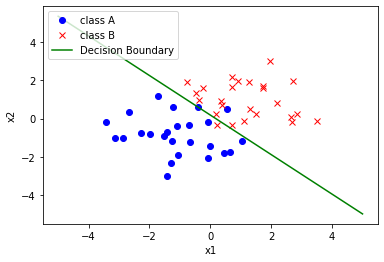

In [14]:
# plot the learned decision boundary
W = W.detach().numpy()
b = b.detach().numpy()

xx = np.linspace(-5, 5, 50)
yy = decision_boundary(xx, bias=b, weights=W)

plt.plot(X_classA[:, 0], X_classA[:, 1], "bo", label="class A")
plt.plot(X_classB[:, 0], X_classB[:, 1], "rx", label="class B")
plt.plot(xx, yy, "g-", label="Decision Boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(loc="upper left")
plt.show()

## More difficult data + deeper networks

(100, 2) (100, 2)


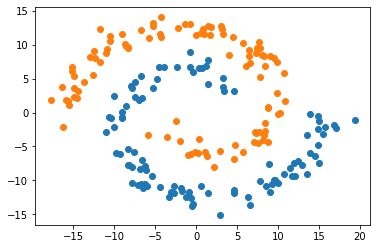

In [15]:
from numpy import pi

N = 100
theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

print(x_a.shape, x_b.shape)

plt.scatter(x_a[:, 0], x_a[:, 1])
plt.scatter(x_b[:, 0], x_b[:, 1])
plt.show()

In [16]:
X = np.concatenate((x_a, x_b))
y = np.ones((N*2, ))
y[100:] = 0

X, y = torch.from_numpy(X), torch.from_numpy(y)
X, y = X.to(torch.float32), y.to(torch.float32)

print(X.shape, y.shape)

torch.Size([200, 2]) torch.Size([200])


In [114]:
# 2-layer neural network

# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim

INP_DIM = 2 # number of features
OUT_DIM = 2 # number of classes

class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(INP_DIM, 4),
            nn.ReLU(),
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
        )
        
    def forward(self, x):
        x = self.layers(x)
        x = torch.sigmoid(x)
        return x

num parameters: 30
final accuracy: 98.0%


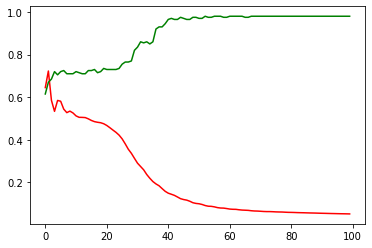

In [115]:
model = DeepNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = nn.BCELoss()

EPOCHS = 100
losses = []
accuracies = []
for epoch in range(EPOCHS):
    
    # feed the whole dataset
    out = model(X)
    out = out.reshape(-1)
    loss = criterion(out, y)
    losses.append(loss)
    
    preds = out > 0.5
    accuracy = np.sum(preds.detach().numpy() == y.numpy()) / X.shape[0]
    accuracies.append(accuracy)
    
    loss.backward()
    optimizer.step()
    
    model.zero_grad()
    
print(f"num parameters: {n_parameters(model)}")
# print_parameters(model)
print(f"final accuracy: {accuracy*100}%")
plt.plot(losses, "r-", label="loss")
plt.plot(accuracies, "g-", label="acc")
plt.show() 

(100, 100) (100, 100) (10000, 1)


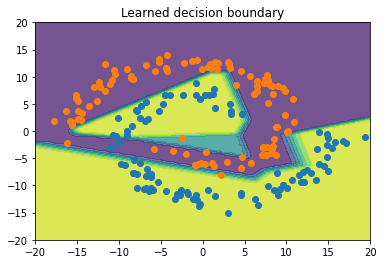

In [117]:
# visualize decision boundaries by (1) creating a grid and (2) letting
# the network predict every single value in that grid

# generate grid
x1, x2 = np.linspace(-20, 20, 100), np.linspace(-20, 20, 100)
xx1, xx2 = np.meshgrid(x1, x2)
X_grid = np.c_[xx1.ravel(), xx2.ravel()]

# predict every point in grid
X_grid = torch.from_numpy(X_grid).to(torch.float32)
preds = model(X_grid).detach().numpy()

print(xx1.shape, xx2.shape, preds.shape)
preds = preds.reshape(xx1.shape)
plt.contourf(xx1, xx2, preds, alpha = 0.75)
plt.scatter(X[:N, 0], X[:N, 1])
plt.scatter(X[N:, 0], X[N:, 1])
plt.title("Learned decision boundary")
plt.show()

In [133]:
# how different architectures fit spiral data
INP_DIM = 2
OUT_DIM = 1
wide_architectures = [[(2, i), (i, 1)] for i in range(4, 10, 1)]
deep_architectures = [
    [(2, 5), (5, 5), (5, 1)],
    [(2, 3), (3, 5), (5, 1)],
    [(2, 10), (10, 5), (5, 1)]
]
architectures = wide_architectures + deep_architectures

class DynamicDeepNet(nn.Module):
    def __init__(self, architecture):
        super(DynamicDeepNet, self).__init__()
        layers = []
        for i, (dim_in, dim_out) in enumerate(architecture):
            layers.append(nn.Linear(dim_in, dim_out))
            layers.append(nn.ReLU())
        
        # drop last ReLU
        layers.pop()
        
        self.layers = nn.Sequential(*layers)       
        
    def forward(self, x):
        x = self.layers(x)
        x = torch.sigmoid(x)
        return x
    
def train(model, optim, criterion, X, y, n_epochs):
    for epoch in range(n_epochs):
        out = model(X)
        out = out.reshape(-1)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        model.zero_grad()
        
def plot_decision_boundary(model, architecture):
    # visualize decision boundaries by (1) creating a grid and (2) letting
    # the network predict every single value in that grid

    # generate grid
    x1, x2 = np.linspace(-20, 20, 100), np.linspace(-20, 20, 100)
    xx1, xx2 = np.meshgrid(x1, x2)
    X_grid = np.c_[xx1.ravel(), xx2.ravel()]

    # predict every point in grid
    X_grid = torch.from_numpy(X_grid).to(torch.float32)
    preds = model(X_grid).detach().numpy()

    preds = preds.reshape(xx1.shape)
    plt.contourf(xx1, xx2, preds, alpha = 0.75)
    plt.scatter(X[:N, 0], X[:N, 1])
    plt.scatter(X[N:, 0], X[N:, 1])
    plt.title(f"Architecture: {architecture}")
    plt.show()

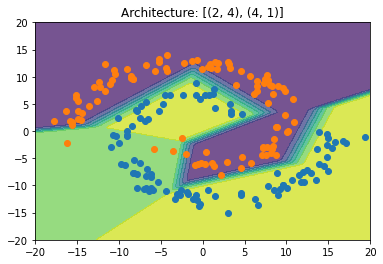

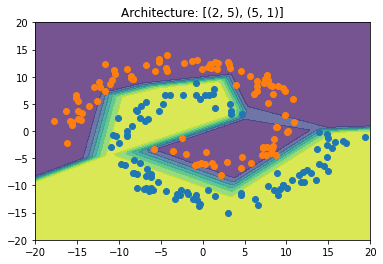

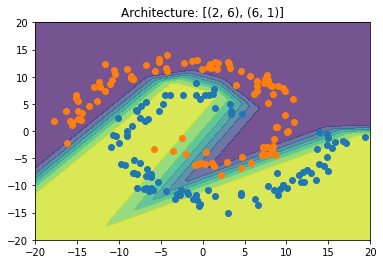

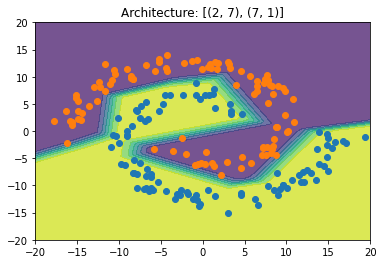

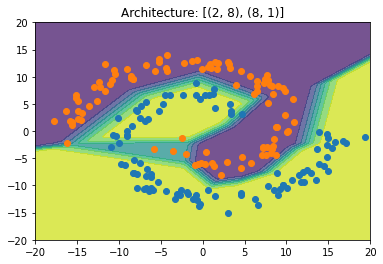

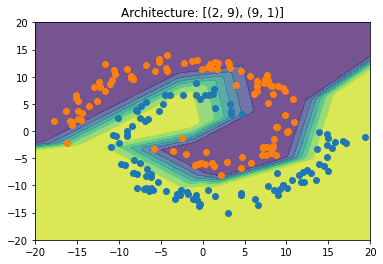

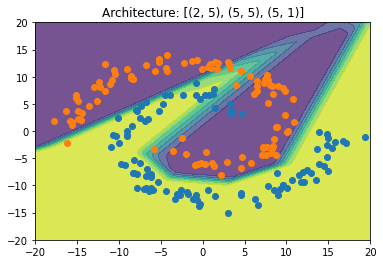

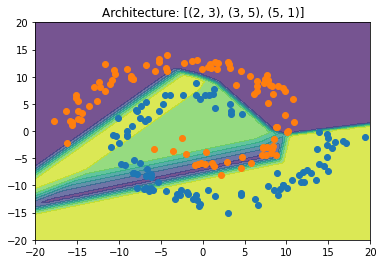

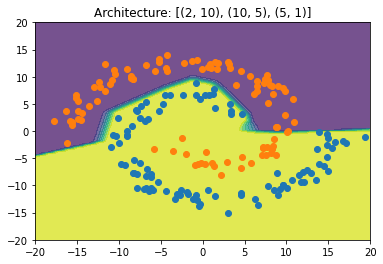

In [134]:
for architecture in architectures:
    model = DynamicDeepNet(architecture)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    criterion = nn.BCELoss()
    train(model, optimizer, criterion, X, y, n_epochs=100)
    plot_decision_boundary(model, architecture)